In [1]:
import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2023-11-30 09:51:27.522956: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 09:51:27.524869: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 09:51:27.555688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 09:51:27.555729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 09:51:27.556520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Loading MODData from "experiments"

In [2]:
data: MODData = MODData.load("../../../../re2fractive_onedrive/data/mod.data_feature_selected.pkl")

2023-11-30 09:51:35,450 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f9040213b80> object, created with modnet version 0.2.1


In [3]:
data.df_featurized

,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicOrbitals|gap_AO,AtomicPackingEfficiency|mean simul. packing efficiency,AtomicPackingEfficiency|mean abs simul. packing efficiency,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,...,VoronoiFingerprint|mean Voro_area_maximum,VoronoiFingerprint|std_dev Voro_area_maximum,VoronoiFingerprint|mean Voro_dist_mean,VoronoiFingerprint|std_dev Voro_dist_mean,VoronoiFingerprint|mean Voro_dist_std_dev,VoronoiFingerprint|std_dev Voro_dist_std_dev,VoronoiFingerprint|mean Voro_dist_minimum,VoronoiFingerprint|std_dev Voro_dist_minimum,VoronoiFingerprint|mean Voro_dist_maximum,VoronoiFingerprint|std_dev Voro_dist_maximum
id,,,,,,,,,,,,,,,,,,,,,
mp-755116,3.0,78,-0.273634,3.0,78,-0.273634,0.000000,-0.031815,0.031815,0.064282,...,4.400785,0.132124,2.736224,0.208690,0.467059,0.210464,2.064988,0.078563,3.377776,0.458776
mp-755478,2.0,8,-0.338381,2.0,8,-0.338381,0.000000,0.005285,0.013314,0.020412,...,6.704337,0.361393,3.150719,0.185900,0.630736,0.106049,2.219102,0.068728,4.084165,0.184609
mp-17998,3.0,45,-0.239422,3.0,45,-0.239422,0.000000,0.019235,0.032468,0.053452,...,4.414231,0.340455,2.716448,0.163359,0.463026,0.088636,2.120453,0.112051,3.501111,0.171479
mp-754065,2.0,8,-0.338381,2.0,8,-0.338381,0.000000,-0.028964,0.030704,0.033259,...,5.273731,0.608247,2.837959,0.437157,0.465939,0.250315,2.069003,0.132846,3.796428,0.976473
mp-553961,2.0,8,-0.338381,1.0,21,-0.156478,0.181903,-0.019762,0.033897,0.017750,...,5.049319,0.215777,2.753045,0.260710,0.518376,0.048432,1.985772,0.073579,3.874981,0.420384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-698480,2.0,8,-0.338381,2.0,8,-0.338381,0.000000,0.000000,0.000000,0.146979,...,6.755468,1.877188,3.122917,0.205950,0.800698,0.131879,1.619887,0.417271,4.356481,0.277054
mp-23740,2.0,8,-0.338381,2.0,8,-0.338381,0.000000,0.000000,0.000000,0.134658,...,5.763350,0.537519,2.868246,0.163738,0.677551,0.116411,1.523910,0.349452,3.742030,0.160967
mp-8333,2.0,9,-0.415606,1.0,50,-0.369349,0.046257,0.000000,0.000000,0.772358,...,5.565581,0.726489,3.043532,0.446536,0.534483,0.195537,2.137459,0.299796,4.097413,0.772753


In [4]:
kf = KFold(300, shuffle=True, random_state=42)
for ind, (train, test) in enumerate(
    kf.split(data.df_featurized, y=data.df_targets)
):
    if ind==1:
        train_moddata, test_moddata = data.split((train, test))
    else:
        continue


In [5]:
len(test_moddata.df_featurized)

14

In [6]:
test_moddata.df_structure.iloc[0].structure

Structure Summary
Lattice
    abc : 5.190223 5.231628 5.28808368503875
 angles : 80.15798500988447 90.0 90.0
 volume : 141.47578177508024
      A : 5.190223 0.0 0.0
      B : 0.0 5.231628 0.0
      C : 0.0 0.903903 5.210258
    pbc : <Periodicity.PERIODIC: 1> <Periodicity.PERIODIC: 1> <Periodicity.PERIODIC: 1>
PeriodicSite: Sc (2.7315, 1.8742, 1.4990) [0.5263, 0.3085, 0.2877]
PeriodicSite: Sc (0.1364, 3.8093, 1.1061) [0.0263, 0.6915, 0.2123]
PeriodicSite: Sc (2.4587, 4.2613, 3.7112) [0.4737, 0.6915, 0.7123]
PeriodicSite: Sc (5.0538, 2.3262, 4.1042) [0.9737, 0.3085, 0.7877]
PeriodicSite: O (1.3166, 2.4072, 0.0642) [0.2537, 0.4580, 0.0123]
PeriodicSite: O (3.9117, 3.2764, 2.5410) [0.7537, 0.5420, 0.4877]
PeriodicSite: O (3.8736, 3.7283, 5.1461) [0.7463, 0.5420, 0.9877]
PeriodicSite: O (1.2785, 2.8591, 2.6693) [0.2463, 0.4580, 0.5123]
PeriodicSite: F (3.5024, 0.8879, 3.4280) [0.6748, 0.0560, 0.6579]
PeriodicSite: F (0.9073, 5.6996, 4.3874) [0.1748, 0.9440, 0.8421]
PeriodicSite: F (1.6878,

In [17]:
test_moddata = MODData(structures=test_moddata.df_structure.values.flatten())
test_moddata.df_featurized = None
test_moddata.featurizer.featurizer_mode = "single"
test_moddata.featurize(n_jobs=6)

# data.save("mod.data_featselec_opti_v0_bis")

2023-11-30 10:02:53,885 - modnet - INFO - Loaded Matminer2023Featurizer featurizer.
2023-11-30 10:02:53,887 - modnet - INFO - Computing features, this can take time...
2023-11-30 10:02:53,888 - modnet - INFO - Applying composition featurizers...
2023-11-30 10:02:53,892 - modnet - INFO - Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7f8fbd490be0>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'm

AtomicOrbitals: 100%|██████████| 14/14 [00:00<00:00, 3871.32it/s]

2023-11-30 10:02:53,911 - modnet - INFO - Applied featurizer AtomicOrbitals to column 'composition' in 0.016373102 seconds
2023-11-30 10:02:53,912 - modnet - INFO - Fitting featurizer AtomicPackingEfficiency to column ('Input Data', 'composition').
2023-11-30 10:02:53,914 - modnet - INFO - Fitted featurizer AtomicPackingEfficiency to column ('Input Data', 'composition') in 0.0013809500000000001 seconds
2023-11-30 10:02:53,914 - modnet - INFO - Applying featurizer AtomicPackingEfficiency to column ('Input Data', 'composition').



AtomicPackingEfficiency: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

2023-11-30 10:02:58,870 - modnet - INFO - Applied featurizer AtomicPackingEfficiency to column ('Input Data', 'composition') in 4.9546163110000006 seconds
2023-11-30 10:02:58,871 - modnet - INFO - Fitting featurizer BandCenter to column ('Input Data', 'composition').
2023-11-30 10:02:58,872 - modnet - INFO - Fitted featurizer BandCenter to column ('Input Data', 'composition') in 0.00067957 seconds
2023-11-30 10:02:58,872 - modnet - INFO - Applying featurizer BandCenter to column ('Input Data', 'composition').



BandCenter: 100%|██████████| 14/14 [00:01<00:00,  9.24it/s]

2023-11-30 10:03:00,400 - modnet - INFO - Applied featurizer BandCenter to column ('Input Data', 'composition') in 1.527263397 seconds
2023-11-30 10:03:00,401 - modnet - INFO - Fitting featurizer ElementFraction to column ('Input Data', 'composition').
2023-11-30 10:03:00,401 - modnet - INFO - Fitted featurizer ElementFraction to column ('Input Data', 'composition') in 0.000771755 seconds
2023-11-30 10:03:00,402 - modnet - INFO - Applying featurizer ElementFraction to column ('Input Data', 'composition').



ElementFraction: 100%|██████████| 14/14 [00:00<00:00, 9295.59it/s]

2023-11-30 10:03:00,425 - modnet - INFO - Applied featurizer ElementFraction to column ('Input Data', 'composition') in 0.022737059 seconds
2023-11-30 10:03:00,427 - modnet - INFO - Fitting featurizer ElementProperty to column ('Input Data', 'composition').
2023-11-30 10:03:00,428 - modnet - INFO - Fitted featurizer ElementProperty to column ('Input Data', 'composition') in 0.0015738470000000002 seconds
2023-11-30 10:03:00,429 - modnet - INFO - Applying featurizer ElementProperty to column ('Input Data', 'composition').



ElementProperty: 100%|██████████| 14/14 [00:00<00:00, 276.54it/s]

2023-11-30 10:03:00,503 - modnet - INFO - Applied featurizer ElementProperty to column ('Input Data', 'composition') in 0.07331475300000001 seconds
2023-11-30 10:03:00,505 - modnet - INFO - Fitting featurizer IonProperty to column ('Input Data', 'composition').
2023-11-30 10:03:00,505 - modnet - INFO - Fitted featurizer IonProperty to column ('Input Data', 'composition') in 0.000773239 seconds
2023-11-30 10:03:00,506 - modnet - INFO - Applying featurizer IonProperty to column ('Input Data', 'composition').



IonProperty: 100%|██████████| 14/14 [00:00<00:00, 29.51it/s]

2023-11-30 10:03:00,997 - modnet - INFO - Applied featurizer IonProperty to column ('Input Data', 'composition') in 0.49079085100000003 seconds
2023-11-30 10:03:00,998 - modnet - INFO - Fitting featurizer Miedema to column ('Input Data', 'composition').
2023-11-30 10:03:00,998 - modnet - INFO - Fitted featurizer Miedema to column ('Input Data', 'composition') in 0.000624015 seconds
2023-11-30 10:03:00,999 - modnet - INFO - Applying featurizer Miedema to column ('Input Data', 'composition').



Miedema:   0%|          | 0/14 [00:00<?, ?it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: Runt

2023-11-30 10:03:01,107 - modnet - INFO - Applied featurizer Miedema to column ('Input Data', 'composition') in 0.10727397400000001 seconds
2023-11-30 10:03:01,109 - modnet - INFO - Fitting featurizer Stoichiometry to column ('Input Data', 'composition').
2023-11-30 10:03:01,111 - modnet - INFO - Fitted featurizer Stoichiometry to column ('Input Data', 'composition') in 0.0018163130000000002 seconds
2023-11-30 10:03:01,112 - modnet - INFO - Applying featurizer Stoichiometry to column ('Input Data', 'composition').



Stoichiometry: 100%|██████████| 14/14 [00:00<00:00, 6518.68it/s]

2023-11-30 10:03:01,139 - modnet - INFO - Applied featurizer Stoichiometry to column ('Input Data', 'composition') in 0.026401507 seconds
2023-11-30 10:03:01,142 - modnet - INFO - Fitting featurizer TMetalFraction to column ('Input Data', 'composition').
2023-11-30 10:03:01,144 - modnet - INFO - Fitted featurizer TMetalFraction to column ('Input Data', 'composition') in 0.0016570990000000002 seconds
2023-11-30 10:03:01,145 - modnet - INFO - Applying featurizer TMetalFraction to column ('Input Data', 'composition').



TMetalFraction: 100%|██████████| 14/14 [00:00<00:00, 28940.49it/s]

2023-11-30 10:03:01,174 - modnet - INFO - Applied featurizer TMetalFraction to column ('Input Data', 'composition') in 0.027189603000000003 seconds


2023-11-30 10:03:01,176 - modnet - INFO - Fitting featurizer ValenceOrbital to column ('Input Data', 'composition').
2023-11-30 10:03:01,178 - modnet - INFO - Fitted featurizer ValenceOrbital to column ('Input Data', 'composition') in 0.002486767 seconds
2023-11-30 10:03:01,180 - modnet - INFO - Applying featurizer ValenceOrbital to column ('Input Data', 'composition').


ValenceOrbital: 100%|██████████| 14/14 [00:00<00:00, 3751.61it/s]


2023-11-30 10:03:01,213 - modnet - INFO - Applied featurizer ValenceOrbital to column ('Input Data', 'composition') in 0.032067901 seconds
2023-11-30 10:03:01,215 - modnet - INFO - Fitting featurizer YangSolidSolution to column ('Input Data', 'composition').
2023-11-30 10:03:01,216 - modnet - INFO - Fitted featurizer YangSolidSolution to column ('Input Data', 'composition') in 0.0013684720000000001 seconds
2023-11-30 10:03:01,218 - modnet - INFO - Applying featurizer YangSolidSolution to column ('Input Data', 'composition').


YangSolidSolution: 100%|██████████| 14/14 [00:00<00:00, 2238.33it/s]

2023-11-30 10:03:01,250 - modnet - INFO - Applied featurizer YangSolidSolution to column ('Input Data', 'composition') in 0.031085734 seconds
2023-11-30 10:03:01,251 - modnet - INFO - Applied all featurizers
2023-11-30 10:03:01,256 - modnet - INFO - Applying oxidation state featurizers...



CompositionToOxidComposition: 100%|██████████| 14/14 [00:00<00:00, 30.99it/s]


2023-11-30 10:03:03,376 - modnet - INFO - Applying featurizers (ElectronegativityDiff(stats=['minimum', 'maximum', 'range', 'mean', 'std_dev']), OxidationStates(stats=['minimum', 'maximum', 'range', 'std_dev'])) to column 'composition_oxid'.
2023-11-30 10:03:03,378 - modnet - INFO - Fitting featurizer ElectronegativityDiff to column 'composition_oxid'.
2023-11-30 10:03:03,379 - modnet - INFO - Fitted featurizer ElectronegativityDiff to column 'composition_oxid' in 0.001335631 seconds
2023-11-30 10:03:03,381 - modnet - INFO - Applying featurizer ElectronegativityDiff to column 'composition_oxid'.


ElectronegativityDiff: 100%|██████████| 14/14 [00:00<00:00, 2320.41it/s]

2023-11-30 10:03:03,424 - modnet - INFO - Applied featurizer ElectronegativityDiff to column 'composition_oxid' in 0.040454210000000004 seconds
2023-11-30 10:03:03,425 - modnet - INFO - Fitting featurizer OxidationStates to column ('Input Data', 'composition_oxid').
2023-11-30 10:03:03,428 - modnet - INFO - Fitted featurizer OxidationStates to column ('Input Data', 'composition_oxid') in 0.0032774830000000003 seconds
2023-11-30 10:03:03,429 - modnet - INFO - Applying featurizer OxidationStates to column ('Input Data', 'composition_oxid').



OxidationStates: 100%|██████████| 14/14 [00:00<00:00, 3793.79it/s]

2023-11-30 10:03:03,460 - modnet - INFO - Applied featurizer OxidationStates to column ('Input Data', 'composition_oxid') in 0.029692296000000003 seconds
2023-11-30 10:03:03,462 - modnet - INFO - Applied all featurizers
2023-11-30 10:03:03,478 - modnet - INFO - Applying structure featurizers...
2023-11-30 10:03:03,493 - modnet - INFO - Applying featurizers (DensityFeatures(), GlobalSymmetryFeatures(), RadialDistributionFunction(), CoulombMatrix(), SineCoulombMatrix(), EwaldEnergy(), BondFractions(), StructuralHeterogeneity(), MaximumPackingEfficiency(), ChemicalOrdering(), XRDPowderPattern(pattern_length=128)) to column 'structure'.
2023-11-30 10:03:03,496 - modnet - INFO - Fitting featurizer DensityFeatures to column 'structure'.
2023-11-30 10:03:03,498 - modnet - INFO - Fitted featurizer DensityFeatures to column 'structure' in 0.002018092 seconds
2023-11-30 10:03:03,498 - modnet - INFO - Applying featurizer DensityFeatures to column 'structure'.



DensityFeatures: 100%|██████████| 14/14 [00:00<00:00, 239.31it/s]

2023-11-30 10:03:03,571 - modnet - INFO - Applied featurizer DensityFeatures to column 'structure' in 0.072282703 seconds
2023-11-30 10:03:03,572 - modnet - INFO - Fitting featurizer GlobalSymmetryFeatures to column ('Input Data', 'structure').
2023-11-30 10:03:03,574 - modnet - INFO - Fitted featurizer GlobalSymmetryFeatures to column ('Input Data', 'structure') in 0.0019478910000000002 seconds
2023-11-30 10:03:03,575 - modnet - INFO - Applying featurizer GlobalSymmetryFeatures to column ('Input Data', 'structure').



GlobalSymmetryFeatures: 100%|██████████| 14/14 [00:00<00:00, 117.90it/s]


2023-11-30 10:03:03,709 - modnet - INFO - Applied featurizer GlobalSymmetryFeatures to column ('Input Data', 'structure') in 0.13367221 seconds
2023-11-30 10:03:03,712 - modnet - INFO - Fitting featurizer RadialDistributionFunction to column ('Input Data', 'structure').
2023-11-30 10:03:03,713 - modnet - INFO - Fitted featurizer RadialDistributionFunction to column ('Input Data', 'structure') in 0.001258666 seconds
2023-11-30 10:03:03,714 - modnet - INFO - Applying featurizer RadialDistributionFunction to column ('Input Data', 'structure').


RadialDistributionFunction: 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

2023-11-30 10:03:10,618 - modnet - INFO - Applied featurizer RadialDistributionFunction to column ('Input Data', 'structure') in 6.903162631000001 seconds
2023-11-30 10:03:10,619 - modnet - INFO - Fitting featurizer CoulombMatrix to column ('Input Data', 'structure').
2023-11-30 10:03:10,620 - modnet - INFO - Fitted featurizer CoulombMatrix to column ('Input Data', 'structure') in 0.0009746640000000001 seconds
2023-11-30 10:03:10,620 - modnet - INFO - Applying featurizer CoulombMatrix to column ('Input Data', 'structure').



CoulombMatrix:  43%|████▎     | 6/14 [00:00<00:00, 55.45it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/structure/matrix.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
CoulombMatrix: 100%|██████████| 14/14 [00:00<00:00, 22.69it/s]

2023-11-30 10:03:11,248 - modnet - INFO - Applied featurizer CoulombMatrix to column ('Input Data', 'structure') in 0.627573441 seconds
2023-11-30 10:03:11,249 - modnet - INFO - Fitting featurizer SineCoulombMatrix to column ('Input Data', 'structure').
2023-11-30 10:03:11,250 - modnet - INFO - Fitted featurizer SineCoulombMatrix to column ('Input Data', 'structure') in 0.000812819 seconds
2023-11-30 10:03:11,251 - modnet - INFO - Applying featurizer SineCoulombMatrix to column ('Input Data', 'structure').



SineCoulombMatrix:  71%|███████▏  | 10/14 [00:00<00:00, 99.50it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
SineCoulombMatrix: 100%|██████████| 14/14 [00:00<00:00, 69.17it/s]

2023-11-30 10:03:11,466 - modnet - INFO - Applied featurizer SineCoulombMatrix to column ('Input Data', 'structure') in 0.215167732 seconds
2023-11-30 10:03:11,468 - modnet - INFO - Fitting featurizer EwaldEnergy to column ('Input Data', 'structure').
2023-11-30 10:03:11,468 - modnet - INFO - Fitted featurizer EwaldEnergy to column ('Input Data', 'structure') in 0.000702328 seconds
2023-11-30 10:03:11,469 - modnet - INFO - Applying featurizer EwaldEnergy to column ('Input Data', 'structure').



EwaldEnergy: 100%|██████████| 14/14 [00:00<00:00, 3264.78it/s]

2023-11-30 10:03:11,491 - modnet - INFO - Applied featurizer EwaldEnergy to column ('Input Data', 'structure') in 0.021605154 seconds
2023-11-30 10:03:11,495 - modnet - INFO - Fitting featurizer BondFractions to column ('Input Data', 'structure').
2023-11-30 10:03:11,498 - modnet - INFO - Fitted featurizer BondFractions to column ('Input Data', 'structure') in 0.002763324 seconds
2023-11-30 10:03:11,499 - modnet - INFO - Applying featurizer BondFractions to column ('Input Data', 'structure').



BondFractions:   0%|          | 0/14 [00:00<?, ?it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4155: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3949: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
BondFractions: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]

2023-11-30 10:03:21,425 - modnet - INFO - Applied featurizer BondFractions to column ('Input Data', 'structure') in 9.925268934 seconds
2023-11-30 10:03:21,425 - modnet - INFO - Fitting featurizer StructuralHeterogeneity to column ('Input Data', 'structure').
2023-11-30 10:03:21,426 - modnet - INFO - Fitted featurizer StructuralHeterogeneity to column ('Input Data', 'structure') in 0.0007307790000000001 seconds
2023-11-30 10:03:21,426 - modnet - INFO - Applying featurizer StructuralHeterogeneity to column ('Input Data', 'structure').



StructuralHeterogeneity: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]

2023-11-30 10:03:34,145 - modnet - INFO - Applied featurizer StructuralHeterogeneity to column ('Input Data', 'structure') in 12.718614098000002 seconds
2023-11-30 10:03:34,146 - modnet - INFO - Fitting featurizer MaximumPackingEfficiency to column ('Input Data', 'structure').
2023-11-30 10:03:34,147 - modnet - INFO - Fitted featurizer MaximumPackingEfficiency to column ('Input Data', 'structure') in 0.001088096 seconds
2023-11-30 10:03:34,148 - modnet - INFO - Applying featurizer MaximumPackingEfficiency to column ('Input Data', 'structure').



MaximumPackingEfficiency: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]

2023-11-30 10:03:56,456 - modnet - INFO - Applied featurizer MaximumPackingEfficiency to column ('Input Data', 'structure') in 22.307268904 seconds
2023-11-30 10:03:56,457 - modnet - INFO - Fitting featurizer ChemicalOrdering to column ('Input Data', 'structure').
2023-11-30 10:03:56,458 - modnet - INFO - Fitted featurizer ChemicalOrdering to column ('Input Data', 'structure') in 0.00078175 seconds
2023-11-30 10:03:56,459 - modnet - INFO - Applying featurizer ChemicalOrdering to column ('Input Data', 'structure').



ChemicalOrdering: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]

2023-11-30 10:04:13,953 - modnet - INFO - Applied featurizer ChemicalOrdering to column ('Input Data', 'structure') in 17.493868483 seconds
2023-11-30 10:04:13,954 - modnet - INFO - Fitting featurizer XRDPowderPattern to column ('Input Data', 'structure').
2023-11-30 10:04:13,956 - modnet - INFO - Fitted featurizer XRDPowderPattern to column ('Input Data', 'structure') in 0.001426504 seconds
2023-11-30 10:04:13,957 - modnet - INFO - Applying featurizer XRDPowderPattern to column ('Input Data', 'structure').



XRDPowderPattern: 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]

2023-11-30 10:04:16,647 - modnet - INFO - Applied featurizer XRDPowderPattern to column ('Input Data', 'structure') in 2.689766741 seconds
2023-11-30 10:04:16,647 - modnet - INFO - Applied all featurizers
2023-11-30 10:04:16,652 - modnet - INFO - Applying site featurizers...



SiteStatsFingerprint: 100%|██████████| 14/14 [00:00<00:00, 44.48it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:245: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):

/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:245: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
SiteStatsFingerprint: 100%|██████████| 14/14 [00:00<00:00, 41.84it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4155: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3949: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to n

2023-11-30 10:06:59,886 - modnet - INFO - Data has successfully been featurized!


In [26]:
test_moddata.df_featurized.filter(like='Radial', axis=1)

,RadialDistributionFunction|rdf [0.00000 - 0.10000]A,RadialDistributionFunction|rdf [0.10000 - 0.20000]A,RadialDistributionFunction|rdf [0.20000 - 0.30000]A,RadialDistributionFunction|rdf [0.30000 - 0.40000]A,RadialDistributionFunction|rdf [0.40000 - 0.50000]A,RadialDistributionFunction|rdf [0.50000 - 0.60000]A,RadialDistributionFunction|rdf [0.60000 - 0.70000]A,RadialDistributionFunction|rdf [0.70000 - 0.80000]A,RadialDistributionFunction|rdf [0.80000 - 0.90000]A,RadialDistributionFunction|rdf [0.90000 - 1.00000]A,...,RadialDistributionFunction|rdf [19.00000 - 19.10000]A,RadialDistributionFunction|rdf [19.10000 - 19.20000]A,RadialDistributionFunction|rdf [19.20000 - 19.30000]A,RadialDistributionFunction|rdf [19.30000 - 19.40000]A,RadialDistributionFunction|rdf [19.40000 - 19.50000]A,RadialDistributionFunction|rdf [19.50000 - 19.60000]A,RadialDistributionFunction|rdf [19.60000 - 19.70000]A,RadialDistributionFunction|rdf [19.70000 - 19.80000]A,RadialDistributionFunction|rdf [19.80000 - 19.90000]A,RadialDistributionFunction|rdf [19.90000 - 20.00000]A
id,,,,,,,,,,,,,,,,,,,,,
id0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.787544,9.926226,13.367878,10.824599,10.019180,7.658630,8.066832,9.813322,12.190991,13.200559
id1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.309556,40.599895,41.653639,33.563085,33.309120,50.660042,46.873435,50.427138,54.253699,47.276123
id2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.128967,30.606592,36.646469,36.083629,35.713544,37.524454,33.913629,46.360049,47.476679,40.734994
id3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.384926,1.990107,13.129897,11.695084,11.092838,9.547519,8.820552,5.924917,4.321852,3.973017
id4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.311633,25.119341,19.194954,22.422771,20.343396,25.627398,23.857270,28.997216,22.787070,26.953850
id5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.815446,24.021371,29.432554,28.008777,15.154426,25.243549,22.814465,20.791636,19.872929,24.124318
id6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,68.203285,69.173160,72.890765,63.819069,74.385725,64.042683,63.835814,66.964921,68.377110,66.059071
id7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.643546,33.506806,41.041786,39.004691,43.396947,41.900036,20.867753,22.722666,44.732982,33.657099
id8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.763784,59.838749,53.161023,55.093745,48.697288,58.022728,49.214541,55.861328,53.237216,48.426226


In [21]:
test_moddata.featurizer.oxid_composition_featurizers

(ElectronegativityDiff(stats=['minimum', 'maximum', 'range', 'mean', 'std_dev']),
 OxidationStates(stats=['minimum', 'maximum', 'range', 'std_dev']))

In [22]:
data.featurizer.

(ElectronegativityDiff(stats=['minimum', 'maximum', 'range', 'mean', 'std_dev']),
 OxidationStates(stats=['minimum', 'maximum', 'range', 'std_dev']))

In [7]:
from modnet.featurizers.presets import Matminer2023Featurizer
df_structures = test_moddata.df_structure


featurizer = Matminer2023Featurizer()
featurizer.oxid_composition_featurizers = []
featurizer.featurizer_mode = "multi"
featurizer.set_n_jobs(6)

df_featurized = featurizer.featurize(df_structures)
# df_featurized.to_pickle("df_featurized_bis_Naccarato.pkl")

2023-11-30 09:52:12,171 - modnet - INFO - Applying composition featurizers...
2023-11-30 09:52:12,176 - modnet - INFO - Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7f9015ad16d0>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(), Miedema(ss_types=['min'], struct_types=['inter', 'amor', 'ss']), Stoichiometry(), T

MultipleFeaturizer: 100%|██████████| 14/14 [00:00<00:00, 79.29it/s]
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/composition/alloy.py:198: RuntimeWarning: invalid value encountered in power
  alp_a = np.multiply(1.5, np.power(v_a, 2 / 3)) / reduce(lambda x, y: 1 / x + 1 / y, np.power(n_ws, 1 / 3))
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/compositio

2023-11-30 09:52:18,663 - modnet - INFO - Applying structure featurizers...
2023-11-30 09:52:18,670 - modnet - INFO - Applying featurizers (DensityFeatures(), GlobalSymmetryFeatures(), RadialDistributionFunction(), CoulombMatrix(), SineCoulombMatrix(), EwaldEnergy(), BondFractions(), StructuralHeterogeneity(), MaximumPackingEfficiency(), ChemicalOrdering(), XRDPowderPattern(pattern_length=128)) to column 'structure'.


MultipleFeaturizer: 100%|██████████| 14/14 [00:00<00:00, 72.01it/s]
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4155: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3949: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/structure/matrix.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(e

2023-11-30 09:53:05,985 - modnet - INFO - Applying site featurizers...


SiteStatsFingerprint: 100%|██████████| 14/14 [00:00<00:00, 41.71it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:245: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):

/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:245: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
SiteStatsFingerprint: 100%|██████████| 14/14 [00:00<00:00, 41.14it/s]/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4155: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/vtrinquet/anaconda3/envs/modnenv_v2/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3949: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to no

In [10]:
df_featurized

,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicOrbitals|gap_AO,AtomicPackingEfficiency|mean simul. packing efficiency,AtomicPackingEfficiency|mean abs simul. packing efficiency,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,...,VoronoiFingerprint|mean Voro_area_maximum,VoronoiFingerprint|std_dev Voro_area_maximum,VoronoiFingerprint|mean Voro_dist_mean,VoronoiFingerprint|std_dev Voro_dist_mean,VoronoiFingerprint|mean Voro_dist_std_dev,VoronoiFingerprint|std_dev Voro_dist_std_dev,VoronoiFingerprint|mean Voro_dist_minimum,VoronoiFingerprint|std_dev Voro_dist_minimum,VoronoiFingerprint|mean Voro_dist_maximum,VoronoiFingerprint|std_dev Voro_dist_maximum
id,,,,,,,,,,,,,,,,,,,,,
mp-4661,2,8,-0.338381,1,21,-0.156478,0.181903,NaN,NaN,0.409635,...,4.228550,0.243254,2.776270,0.164518,0.581816,0.101308,2.106284,0.030902,3.826194,0.054194
mp-685194,2,8,-0.338381,3,22,-0.170010,0.168371,0.021848,0.027425,0.023908,...,3.808135,1.308656,2.836354,0.446138,0.412670,0.156594,2.145546,0.525703,3.476975,0.323247
mp-704727,2,8,-0.338381,2,8,-0.338381,0.000000,-0.000734,0.048431,0.030935,...,5.472386,1.438784,2.833150,0.436340,0.616013,0.362744,1.877985,0.332489,4.051805,1.058017
mp-11147,3,29,-0.202272,1,29,-0.172056,0.030216,0.015827,0.035180,0.055556,...,5.246904,1.105375,2.887408,0.365469,0.363047,0.159338,2.221003,0.361468,3.483547,0.783609
mp-17730,2,8,-0.338381,2,8,-0.338381,0.000000,-0.038987,0.058826,0.060435,...,6.724057,0.838832,3.167767,0.275685,0.527691,0.168947,2.249996,0.319786,3.833576,0.331661
mp-18651,3,45,-0.239422,3,45,-0.239422,0.000000,0.027251,0.030927,0.000000,...,4.831272,0.231993,3.062070,0.169153,0.550974,0.029973,2.243032,0.185960,4.065976,0.292600
mp-13772,2,8,-0.338381,2,8,-0.338381,0.000000,0.044523,0.045305,0.019912,...,5.137256,1.086776,2.897452,0.134717,0.489612,0.102207,1.921051,0.456612,3.688582,0.271700
mp-438,2,8,-0.338381,1,72,-0.166465,0.171916,0.058655,0.058655,0.032486,...,5.245520,1.668584,3.034086,0.228363,0.517940,0.141104,2.258000,0.288729,3.937262,0.255098
mp-583646,2,8,-0.338381,2,8,-0.338381,0.000000,0.013324,0.023284,0.060452,...,5.907329,1.193827,2.912551,0.123603,0.596694,0.134076,1.747141,0.457475,3.825758,0.045900


In [38]:
data.cross_nmi = None
data.target_nmi = None
data.df_featurized = df_featurized
data.feature_selection(n=-1,
                       use_precomputed_cross_nmi=False,
                       n_jobs=6)
# data.save("mod.data_featselec_opti_v0_bis")


2023-11-29 23:45:11,481 - modnet - INFO - Multiprocessing on 6 workers.
2023-11-29 23:45:11,482 - modnet - INFO - Computing "self" MI (i.e. information entropy) of features


100%|██████████| 793/793 [00:03<00:00, 219.95it/s]

2023-11-29 23:45:15,659 - modnet - INFO - Computing cross NMI between all features...



100%|██████████| 124750/124750 [08:50<00:00, 235.06it/s]


2023-11-29 23:54:06,959 - modnet - INFO - Starting target 1/1: refractive_index ...
2023-11-29 23:54:06,959 - modnet - INFO - Computing mutual information between features and target...


/home/vtrinquet/Softwares_Packages/Github/modnet/modnet/preprocessing.py:151: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  mutual_info.loc[:, target_name] = _mifun(df_feat, df_target[target_name], **kwargs)


2023-11-29 23:54:25,669 - modnet - INFO - Computing optimal features...
2023-11-29 23:54:30,997 - modnet - INFO - Selected 50/491 features...
2023-11-29 23:54:36,103 - modnet - INFO - Selected 100/491 features...
2023-11-29 23:54:40,882 - modnet - INFO - Selected 150/491 features...
2023-11-29 23:54:45,213 - modnet - INFO - Selected 200/491 features...
2023-11-29 23:54:49,092 - modnet - INFO - Selected 250/491 features...
2023-11-29 23:54:52,394 - modnet - INFO - Selected 300/491 features...
2023-11-29 23:54:55,059 - modnet - INFO - Selected 350/491 features...
2023-11-29 23:54:57,100 - modnet - INFO - Selected 400/491 features...
2023-11-29 23:54:58,364 - modnet - INFO - Selected 450/491 features...
2023-11-29 23:54:58,790 - modnet - INFO - Done with target 1/1: refractive_index.
2023-11-29 23:54:58,791 - modnet - INFO - Merging all features...
2023-11-29 23:54:58,791 - modnet - INFO - Done.
2023-11-29 23:55:00,427 - modnet - INFO - Data successfully saved as mod.data_featselec_opti_v

# New MODData via feature selection

In [7]:
# data.cross_nmi = None
# data.target_nmi = None
# data.feature_selection(n=-1,
#                        use_precomputed_cross_nmi=False,
#                        n_jobs=8)
# data.save("mod.data_featselec_opti_v0")

In [8]:
md = MODData.load("mod.data_featselec_opti_v0")

2023-11-29 13:21:31,790 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fbae9dd0370> object, created with modnet version 0.2.1


# 5-fold cross-validation

In [9]:
kf = KFold(5, shuffle=True, random_state=42)

## Ensemble preset

models/baseline/baseline_kfold_ensemble-refractive_index_0.pkl


2023-11-29 13:21:32.602430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2023-11-29 13:21:32.602455: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 13:21:32.602472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-SE22-351): /proc/driver/nvidia/version does not exist
2023-11-29 13:21:32.602934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-11-29 13:21:33,159 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fbae9eb7a30> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 483us/step
models/baseline/baseline_kfold_ensemble-refractive_index_1.pkl
2023-11-29 13:21:39,933 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba6b5a55e0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 489us/step
models/baseline/baseline_kfold_ensemble-refractive_index_2.pkl
2023-11-29 13:21:46,229 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba67987550> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 615us/step
models/baseline/baseline_kfold_ensemble-refractive_index_3.pkl
2023-11-29 13:21:52,516 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba4d4bb7c0> object, created with modnet version 0.4.1
25

Text(0.5, 1.0, 'MAE: 0.158±0.004')

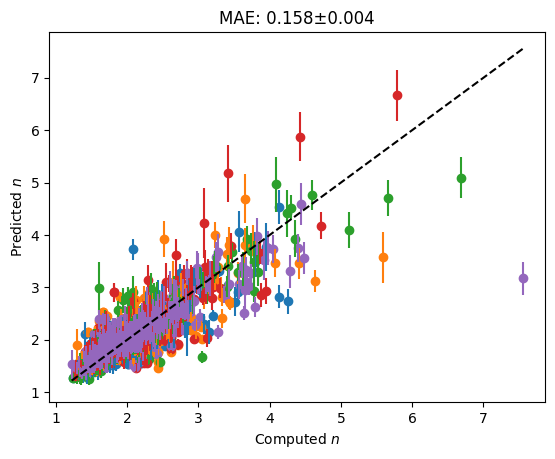

In [10]:
targets = ["refractive_index"]
experiment_name = "baseline_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md.df_featurized, y=md.df_targets)
):
    train_moddata, test_moddata = md.split((train, test))
    model_path = (
        Path(".") / "models" / "baseline" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        model = EnsembleMODNetModel(
            targets=[[["refractive_index"]]],
            weights={"refractive_index": 1.0},
            num_neurons=([128], [32], [32], [16]),
            n_feat=64,
            n_models=32,
        )

        model.fit(
            train_moddata,
            n_jobs=6,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
# plt.savefig(Path(".") / "models" / "baseline" / f"{experiment_name}.pdf")


## Ensemble GA refit 5

models/fitgenetic_1/GA1_kfold_ensemble-refractive_index_0.pkl
2023-11-29 13:22:05,994 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba5cba9640> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 1ms/step
models/fitgenetic_1/GA1_kfold_ensemble-refractive_index_1.pkl
2023-11-29 13:22:08,021 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba5af837f0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 642us/step
models/fitgenetic_1/GA1_kfold_ensemble-refractive_index_2.pkl
2023-11-29 13:22:09,856 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba5aa0ab80> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 955us/step
models/fitgenetic_1/GA1_kfold_ensemble-refractive_index_3.pkl
2023-11-29 13:22:11,727 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7

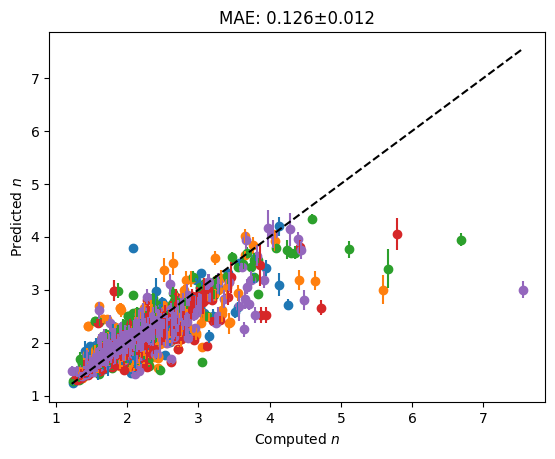

In [11]:
targets = ["refractive_index"]
experiment_name = "GA1_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md.df_featurized, y=md.df_targets)
):
    train_moddata, test_moddata = md.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_1" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=0, # dflt = 5
            n_jobs=8,
            early_stopping=4, # dflt
            refit=5, # dflt
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_1" / f"{experiment_name}.pdf")


## Ensemble GA refit 0

models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_0.pkl
2023-11-29 13:22:17,528 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba59d00550> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 2ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_1.pkl
2023-11-29 13:22:21,721 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba5df33d00> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 907us/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_2.pkl
2023-11-29 13:22:26,030 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fba5d7d4ac0> object, created with modnet version 0.4.1
25/25 [==============================] - 0s 2ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_3.pkl
2023-11-29 13:22:31,125 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fb

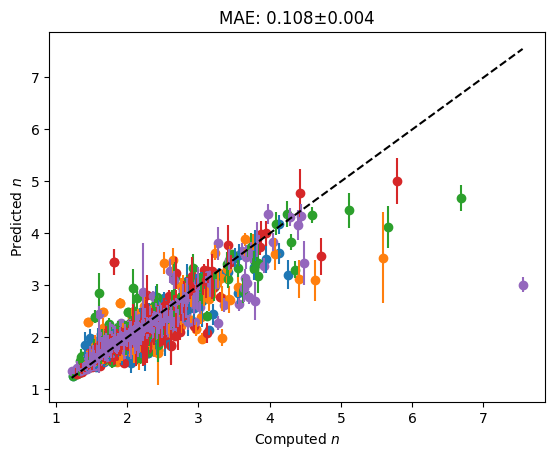

In [12]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md.df_featurized, y=md.df_targets)
):
    train_moddata, test_moddata = md.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=0, # dflt = 5
            n_jobs=8,
            early_stopping=4, # dflt
            refit=0, # dflt = 5
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md.df_targets.values),
        np.max(md.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}.pdf")


# Production

## Training the best model on the whole dataset

In [13]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v0.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=0, # dflt = 5
        n_jobs=8,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2023-11-29 13:22:37,747 - modnet - INFO - Targets:
2023-11-29 13:22:37,747 - modnet - INFO - 1)refractive_index: regression
2023-11-29 13:22:38,132 - modnet - INFO - Multiprocessing on 8 cores. Total of 12 cores available.
2023-11-29 13:22:38,134 - modnet - INFO - Generation number 0


  0%|          | 0/20 [00:00<?, ?it/s]2023-11-29 13:22:41.822904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 13:22:41.941631: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:22:41.946071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2023-11-29 13:22:41.946086: I

13/13 [==============================] - 0s 4ms/step


2023-11-29 13:23:13.738603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2023-11-29 13:23:13.738653: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 13:23:13.738687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-SE22-351): /proc/driver/nvidia/version does not exist
2023-11-29 13:23:13.739057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 0s 2ms/step


 10%|█         | 2/20 [00:37<04:35, 15.32s/it]2023-11-29 13:23:16.630610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 13:23:16.915479: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:23:16.920970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2023-11-29 13:23:16.9

13/13 [==============================] - 0s 4ms/step


2023-11-29 13:23:38.663893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2023-11-29 13:23:38.664016: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 13:23:38.664076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-SE22-351): /proc/driver/nvidia/version does not exist
2023-11-29 13:23:38.664609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
 15%|█▌        | 3

13/13 [==============================] - 0s 5ms/step


 20%|██        | 4/20 [01:14<04:32, 17.01s/it]

13/13 [==============================] - 0s 4ms/step


 25%|██▌       | 5/20 [01:20<03:14, 12.99s/it]

13/13 [==============================] - 0s 3ms/step


 30%|███       | 6/20 [01:39<03:30, 15.04s/it]

13/13 [==============================] - 0s 3ms/step


 35%|███▌      | 7/20 [01:40<02:12, 10.22s/it]

13/13 [==============================] - 0s 4ms/step


 40%|████      | 8/20 [01:45<01:43,  8.61s/it]

13/13 [==============================] - 0s 3ms/step


 45%|████▌     | 9/20 [01:50<01:23,  7.56s/it]

13/13 [==============================] - 0s 7ms/step


 50%|█████     | 10/20 [02:00<01:23,  8.39s/it]

13/13 [==============================] - 0s 4ms/step


 55%|█████▌    | 11/20 [02:39<02:40, 17.79s/it]

13/13 [==============================] - 0s 3ms/step


 60%|██████    | 12/20 [02:47<01:58, 14.82s/it]

13/13 [==============================] - 0s 5ms/step


 65%|██████▌   | 13/20 [03:02<01:43, 14.77s/it]

13/13 [==============================] - 0s 3ms/step


 75%|███████▌  | 15/20 [03:05<00:40,  8.00s/it]

13/13 [==============================] - 0s 2ms/step


 80%|████████  | 16/20 [03:08<00:25,  6.41s/it]

13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 17/20 [03:24<00:28,  9.53s/it]

13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 19/20 [03:25<00:04,  4.77s/it]

13/13 [==============================] - 0s 3ms/step


100%|██████████| 20/20 [03:53<00:00, 11.69s/it]

13/13 [==============================] - 0s 896us/step
2023-11-29 13:26:32,854 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.116 	ind 2: 0.204 	ind 3: 0.112 	ind 4: 0.319 	ind 5: 0.316 	ind 6: 0.315 	ind 7: 0.125 	ind 8: 0.113 	ind 9: 0.113 	ind 10: 0.135 	ind 11: 0.325 	ind 12: 0.128 	ind 13: 0.141 	ind 14: 0.127 	ind 15: 0.112 	ind 16: 0.122 	ind 17: 0.111 	ind 18: 0.106 	ind 19: 0.256 	
2023-11-29 13:26:32,856 - modnet - INFO - Generation number 1



  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 4ms/step


  5%|▌         | 1/20 [00:41<13:15, 41.87s/it]

13/13 [==============================] - 0s 4ms/step


 10%|█         | 2/20 [00:56<07:43, 25.75s/it]

13/13 [==============================] - 0s 5ms/step


 20%|██        | 4/20 [01:32<05:27, 20.44s/it]

13/13 [==============================] - 0s 4ms/step


 25%|██▌       | 5/20 [01:33<03:18, 13.21s/it]

13/13 [==============================] - 0s 4ms/step


 30%|███       | 6/20 [01:36<02:17,  9.82s/it]

13/13 [==============================] - 0s 3ms/step


 35%|███▌      | 7/20 [01:40<01:45,  8.08s/it]

13/13 [==============================] - 0s 3ms/step


 45%|████▌     | 9/20 [01:48<01:06,  6.01s/it]

13/13 [==============================] - 0s 6ms/step


 50%|█████     | 10/20 [02:22<02:26, 14.62s/it]

13/13 [==============================] - 0s 4ms/step


 55%|█████▌    | 11/20 [02:33<02:01, 13.50s/it]

13/13 [==============================] - 0s 5ms/step


 60%|██████    | 12/20 [02:49<01:52, 14.11s/it]

13/13 [==============================] - 0s 4ms/step


 70%|███████   | 14/20 [03:29<01:38, 16.48s/it]

13/13 [==============================] - 0s 3ms/step


 75%|███████▌  | 15/20 [03:34<01:05, 13.05s/it]

13/13 [==============================] - 0s 2ms/step


 80%|████████  | 16/20 [03:35<00:37,  9.50s/it]

13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 17/20 [03:36<00:20,  6.94s/it]

13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 18/20 [03:38<00:10,  5.40s/it]

13/13 [==============================] - 0s 1ms/step


 95%|█████████▌| 19/20 [03:46<00:06,  6.23s/it]

13/13 [==============================] - 0s 1ms/step


100%|██████████| 20/20 [04:10<00:00, 12.54s/it]

13/13 [==============================] - 0s 857us/step
2023-11-29 13:30:44,565 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.110 	ind 2: 0.118 	ind 3: 0.122 	ind 4: 0.151 	ind 5: 0.117 	ind 6: 0.110 	ind 7: 0.126 	ind 8: 0.127 	ind 9: 0.139 	ind 10: 0.104 	ind 11: 0.119 	ind 12: 0.130 	ind 13: 0.108 	ind 14: 0.138 	ind 15: 0.115 	ind 16: 0.121 	ind 17: 0.133 	ind 18: 0.123 	ind 19: 0.102 	
2023-11-29 13:30:44,576 - modnet - INFO - Generation number 2



  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 4ms/step


  5%|▌         | 1/20 [00:49<15:45, 49.76s/it]

13/13 [==============================] - 0s 4ms/step


 10%|█         | 2/20 [01:11<09:56, 33.13s/it]

13/13 [==============================] - 0s 6ms/step


 15%|█▌        | 3/20 [01:20<06:19, 22.30s/it]

13/13 [==============================] - 0s 4ms/step


 20%|██        | 4/20 [01:31<04:45, 17.85s/it]

13/13 [==============================] - 0s 5ms/step


 30%|███       | 6/20 [02:08<04:26, 19.02s/it]

13/13 [==============================] - 0s 4ms/step


 35%|███▌      | 7/20 [02:11<02:58, 13.76s/it]

13/13 [==============================] - 0s 3ms/step


 45%|████▌     | 9/20 [02:17<01:25,  7.77s/it]

13/13 [==============================] - 0s 4ms/step


 50%|█████     | 10/20 [02:32<01:41, 10.14s/it]

13/13 [==============================] - 0s 3ms/step


 55%|█████▌    | 11/20 [02:43<01:31, 10.18s/it]

13/13 [==============================] - 0s 4ms/step


 60%|██████    | 12/20 [02:51<01:16,  9.51s/it]

13/13 [==============================] - 0s 5ms/step


 65%|██████▌   | 13/20 [03:19<01:47, 15.40s/it]

13/13 [==============================] - 0s 4ms/step


 70%|███████   | 14/20 [03:25<01:13, 12.32s/it]

13/13 [==============================] - 0s 3ms/step


 80%|████████  | 16/20 [03:37<00:38,  9.61s/it]

13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 17/20 [03:43<00:25,  8.41s/it]

13/13 [==============================] - 0s 3ms/step


 90%|█████████ | 18/20 [04:21<00:34, 17.34s/it]

13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 19/20 [04:32<00:15, 15.64s/it]

13/13 [==============================] - 0s 1ms/step


100%|██████████| 20/20 [04:41<00:00, 14.08s/it]

13/13 [==============================] - 0s 934us/step
2023-11-29 13:35:27,173 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.119 	ind 2: 0.124 	ind 3: 0.091 	ind 4: 0.099 	ind 5: 0.115 	ind 6: 0.082 	ind 7: 0.168 	ind 8: 0.119 	ind 9: 0.108 	ind 10: 0.127 	ind 11: 0.124 	ind 12: 0.120 	ind 13: 0.112 	ind 14: 0.136 	ind 15: 0.111 	ind 16: 0.111 	ind 17: 0.084 	ind 18: 0.112 	ind 19: 0.160 	
2023-11-29 13:35:27,175 - modnet - INFO - Generation number 3



  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


  5%|▌         | 1/20 [00:23<07:22, 23.30s/it]

13/13 [==============================] - 0s 2ms/step


 10%|█         | 2/20 [00:29<03:58, 13.25s/it]

13/13 [==============================] - 0s 3ms/step


 15%|█▌        | 3/20 [00:42<03:46, 13.31s/it]

13/13 [==============================] - 0s 3ms/step


 20%|██        | 4/20 [01:00<04:01, 15.10s/it]

13/13 [==============================] - 0s 5ms/step


 25%|██▌       | 5/20 [01:25<04:40, 18.73s/it]

13/13 [==============================] - 0s 4ms/step


 30%|███       | 6/20 [01:48<04:40, 20.03s/it]

13/13 [==============================] - 0s 4ms/step


 35%|███▌      | 7/20 [01:50<03:02, 14.01s/it]

13/13 [==============================] - 0s 4ms/step


 40%|████      | 8/20 [02:13<03:24, 17.04s/it]

13/13 [==============================] - 0s 3ms/step


 45%|████▌     | 9/20 [02:28<03:00, 16.44s/it]

13/13 [==============================] - 0s 4ms/step


 50%|█████     | 10/20 [02:53<03:11, 19.15s/it]

13/13 [==============================] - 0s 4ms/step


 55%|█████▌    | 11/20 [03:03<02:27, 16.36s/it]

13/13 [==============================] - 0s 4ms/step


 60%|██████    | 12/20 [03:16<02:00, 15.08s/it]

13/13 [==============================] - 0s 5ms/step


 65%|██████▌   | 13/20 [03:19<01:19, 11.41s/it]

13/13 [==============================] - 0s 4ms/step


 75%|███████▌  | 15/20 [04:00<01:21, 16.32s/it]

13/13 [==============================] - 0s 4ms/step


 80%|████████  | 16/20 [04:02<00:48, 12.02s/it]

13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 17/20 [04:21<00:42, 14.24s/it]

13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 18/20 [04:38<00:29, 14.90s/it]

13/13 [==============================] - 0s 1ms/step


 95%|█████████▌| 19/20 [04:39<00:10, 10.74s/it]

13/13 [==============================] - 0s 1ms/step


100%|██████████| 20/20 [04:54<00:00, 14.73s/it]

13/13 [==============================] - 0s 672us/step
2023-11-29 13:40:22,768 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.128 	ind 2: 0.136 	ind 3: 0.135 	ind 4: 0.122 	ind 5: 0.141 	ind 6: 0.146 	ind 7: 0.157 	ind 8: 0.131 	ind 9: 0.138 	ind 10: 0.128 	ind 11: 0.140 	ind 12: 0.139 	ind 13: 0.112 	ind 14: 0.131 	ind 15: 0.153 	ind 16: 0.125 	ind 17: 0.138 	ind 18: 0.136 	ind 19: 0.122 	
2023-11-29 13:40:22,769 - modnet - INFO - Generation number 4



  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


  5%|▌         | 1/20 [00:28<08:56, 28.26s/it]

13/13 [==============================] - 0s 4ms/step


 15%|█▌        | 3/20 [01:41<10:39, 37.59s/it]

13/13 [==============================] - 0s 3ms/step


 20%|██        | 4/20 [01:53<07:17, 27.35s/it]

13/13 [==============================] - 0s 5ms/step


 25%|██▌       | 5/20 [01:58<04:47, 19.18s/it]

13/13 [==============================] - 0s 4ms/step


 30%|███       | 6/20 [02:14<04:13, 18.14s/it]

13/13 [==============================] - 0s 4ms/step


 35%|███▌      | 7/20 [02:33<04:02, 18.67s/it]

13/13 [==============================] - 0s 4ms/step


 40%|████      | 8/20 [02:53<03:48, 19.07s/it]

13/13 [==============================] - 0s 6ms/step


 50%|█████     | 10/20 [04:04<05:07, 30.71s/it]

13/13 [==============================] - 0s 4ms/step


 55%|█████▌    | 11/20 [04:24<04:05, 27.25s/it]

13/13 [==============================] - 0s 4ms/step


 65%|██████▌   | 13/20 [05:10<03:04, 26.35s/it]

13/13 [==============================] - 0s 3ms/step


 70%|███████   | 14/20 [05:18<02:03, 20.62s/it]

13/13 [==============================] - 0s 3ms/step


 75%|███████▌  | 15/20 [05:21<01:16, 15.37s/it]

13/13 [==============================] - 0s 3ms/step


 80%|████████  | 16/20 [05:22<00:44, 11.16s/it]

13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 17/20 [05:31<00:31, 10.36s/it]

13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 18/20 [05:34<00:16,  8.04s/it]

13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 19/20 [05:47<00:09,  9.79s/it]

13/13 [==============================] - 0s 1ms/step


100%|██████████| 20/20 [06:01<00:00, 18.09s/it]

13/13 [==============================] - 0s 704us/step
2023-11-29 13:46:25,576 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.115 	ind 2: 0.099 	ind 3: 0.111 	ind 4: 0.099 	ind 5: 0.103 	ind 6: 0.113 	ind 7: 0.108 	ind 8: 0.116 	ind 9: 0.126 	ind 10: 0.138 	ind 11: 0.094 	ind 12: 0.093 	ind 13: 0.104 	ind 14: 0.096 	ind 15: 0.110 	ind 16: 0.092 	ind 17: 0.098 	ind 18: 0.106 	ind 19: 0.109 	
2023-11-29 13:46:25,577 - modnet - INFO - Generation number 5



  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 4ms/step


  5%|▌         | 1/20 [00:47<14:57, 47.23s/it]

13/13 [==============================] - 0s 4ms/step


 10%|█         | 2/20 [01:35<14:25, 48.11s/it]

13/13 [==============================] - 0s 4ms/step


 15%|█▌        | 3/20 [01:45<08:36, 30.37s/it]

13/13 [==============================] - 0s 4ms/step


 25%|██▌       | 5/20 [02:05<04:30, 18.06s/it]

13/13 [==============================] - 0s 3ms/step


 30%|███       | 6/20 [02:26<04:27, 19.09s/it]

13/13 [==============================] - 0s 4ms/step


 40%|████      | 8/20 [02:48<02:59, 14.94s/it]

13/13 [==============================] - 0s 5ms/step


 50%|█████     | 10/20 [03:30<02:53, 17.31s/it]

13/13 [==============================] - 0s 3ms/step


 55%|█████▌    | 11/20 [03:33<01:56, 12.90s/it]

13/13 [==============================] - 0s 4ms/step


 60%|██████    | 12/20 [03:45<01:40, 12.57s/it]

13/13 [==============================] - 0s 4ms/step


 65%|██████▌   | 13/20 [03:56<01:24, 12.13s/it]

13/13 [==============================] - 0s 4ms/step


 75%|███████▌  | 15/20 [04:27<01:13, 14.64s/it]

13/13 [==============================] - 0s 4ms/step


 80%|████████  | 16/20 [05:13<01:35, 23.78s/it]

13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 17/20 [05:13<00:50, 16.81s/it]

13/13 [==============================] - 0s 3ms/step


 90%|█████████ | 18/20 [05:32<00:35, 17.57s/it]

 1/13 [=>............................] - ETA: 1s

 95%|█████████▌| 19/20 [05:33<00:12, 12.36s/it]

13/13 [==============================] - 0s 2ms/step


100%|██████████| 20/20 [05:37<00:00, 16.88s/it]

13/13 [==============================] - 0s 980us/step
2023-11-29 13:52:04,127 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.128 	ind 2: 0.121 	ind 3: 0.109 	ind 4: 0.119 	ind 5: 0.132 	ind 6: 0.117 	ind 7: 0.158 	ind 8: 0.134 	ind 9: 0.116 	ind 10: 0.136 	ind 11: 0.149 	ind 12: 0.158 	ind 13: 0.119 	ind 14: 0.127 	ind 15: 0.110 	ind 16: 0.111 	ind 17: 0.128 	ind 18: 0.114 	ind 19: 0.121 	
2023-11-29 13:52:04,128 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2023-11-29 13:52:04,128 - modnet - INFO - Early stopping at generation number 5


2023-11-29 13:52:07,502 - modnet - INFO - Model successfully saved as models/production/GA2_kfold_ensemble-refractive_index_prod_v0.pkl!


## Load MP 2023 DF

In [44]:
# path_df_mp_2023_feat = (
#     Path("./../../../../") / "re2fractive_onedrive" / "data" / "mp_2023_df_featurized_multi.pkl"
# )
# df_mp_2023_feat = pd.read_pickle(path_df_mp_2023_feat)

In [45]:
# df_mp_2023_feat

Please note that this Dataframe of the 2023 MP also includes materials from the Naccarato dataset and probably some materials for which the refractive index is already available on the MP. So we need to filter out those compounds. First, the ones from Naccarato's dataset.

In [46]:
# df_mp_2023_feat = df_mp_2023_feat.filter(items=[mp_id for mp_id in list(df_mp_2023_feat.index.values) if mp_id not in md.structure_ids],
#                                          axis=0)

In [47]:
# len(df_mp_2023_feat)

And now the ones from the MP.

In [48]:
# # # Let's query all of the noncentrosymmetric semiconductors of the MP
# # fields = ['nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'universal_anisotropy', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'has_reconstructed', 'possible_species', 'has_props', 'theoretical', 'database_IDs']
# # fields_atleast = ['formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'material_id', 'structure', 'energy_above_hull', 'is_stable', 'band_gap', 'is_gap_direct', 'is_metal', 'is_magnetic', 'e_electronic', 'n','has_props', 'theoretical', 'database_IDs']
# # with MPRester() as m:
# #     mp_semic_dielec = m.materials.dielectric.search()

# # # Let's dump it as a json file to ease the reuse 
# # dumpfn(mp_semic_dielec, "mp_semic_dielec.json.gz")

# mp_semic_dielec = loadfn("mp_semic_dielec.json.gz")

# df_semic_dielec = pd.DataFrame(columns=['mp_id', 'refractive_index'])

# for mat in tqdm(mp_semic_dielec):
#     new_row = {'mp_id':     mat['material_id'],     'refractive_index':  mat['n']}
#     df_semic_dielec = df_semic_dielec.append(new_row, ignore_index=True)

# df_semic_dielec

In [49]:
# df_mp_2023_feat = df_mp_2023_feat.filter(items=[mp_id for mp_id in list(df_mp_2023_feat.index.values) if mp_id not in df_semic_dielec['mp_id'].values],
#                                          axis=0)

In [50]:
# len(df_mp_2023_feat)

In [27]:
# with open('df_mp_2023_feat_filtered.pkl', 'wb') as f:
#     pickle.dump(df_mp_2023_feat, f)
with open('df_mp_2023_feat_filtered.pkl', 'rb') as f:
    df_mp_2023_feat_filtered = pickle.load(f)

In [31]:
df_mp_2023_feat_filtered.columns.values

array(['AtomicOrbitals|HOMO_character', 'AtomicOrbitals|HOMO_element',
       'AtomicOrbitals|HOMO_energy', ...,
       'VoronoiFingerprint|std_dev Voro_dist_minimum',
       'VoronoiFingerprint|mean Voro_dist_maximum',
       'VoronoiFingerprint|std_dev Voro_dist_maximum'], dtype=object)

In [36]:
for col in data.df_featurized.columns.values:
    if col not in test_moddata.df_featurized.columns.values:
        print(col)

Miedema|Miedema_deltaH_inter
Miedema|Miedema_deltaH_amor
Miedema|Miedema_deltaH_ss_min
CoulombMatrix|coulomb matrix eig 104
CoulombMatrix|coulomb matrix eig 105
CoulombMatrix|coulomb matrix eig 106
CoulombMatrix|coulomb matrix eig 107
CoulombMatrix|coulomb matrix eig 108
CoulombMatrix|coulomb matrix eig 109
CoulombMatrix|coulomb matrix eig 110
CoulombMatrix|coulomb matrix eig 111
CoulombMatrix|coulomb matrix eig 112
CoulombMatrix|coulomb matrix eig 113
CoulombMatrix|coulomb matrix eig 114
CoulombMatrix|coulomb matrix eig 115
CoulombMatrix|coulomb matrix eig 116
CoulombMatrix|coulomb matrix eig 117
CoulombMatrix|coulomb matrix eig 118
CoulombMatrix|coulomb matrix eig 119
CoulombMatrix|coulomb matrix eig 120
CoulombMatrix|coulomb matrix eig 121
CoulombMatrix|coulomb matrix eig 122
CoulombMatrix|coulomb matrix eig 123
CoulombMatrix|coulomb matrix eig 124
CoulombMatrix|coulomb matrix eig 125
CoulombMatrix|coulomb matrix eig 126
CoulombMatrix|coulomb matrix eig 127
CoulombMatrix|coulomb mat

In [ ]:
# CoulombMatrix, SineCoulombMatrix, BondFractions, CrystalNNFingerprint

## Predicting the filtered MP 2023

In [16]:
md_mp = MODData.load("mod.data_featselec_opti_v0")
md_mp.df_featurized = df_mp_2023_feat_filtered
# MODData Hack to get around the fact that the structure IDs have also changed
md_mp.df_structure = df_mp_2023_feat_filtered

2023-11-29 14:18:56,374 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fba5fed36a0> object, created with modnet version 0.2.1


In [26]:
# results = model.predict(md_mp, return_unc=True)

In [19]:
df_mp_2023_feat_filtered[md.df_featurized.columns.values]

KeyError: "['AtomicPackingEfficiency|mean abs simul. packing efficiency', 'AtomicPackingEfficiency|dist from 5 clusters |APE| < 0.010', 'IonProperty|max ionic char', 'IonProperty|avg ionic char', 'Miedema|Miedema_deltaH_inter', 'Miedema|Miedema_deltaH_amor', 'Miedema|Miedema_deltaH_ss_min', 'ElectronegativityDiff|std_dev EN difference', 'OxidationStates|minimum oxidation state', 'OxidationStates|maximum oxidation state', 'OxidationStates|range oxidation state', 'OxidationStates|std_dev oxidation state', 'RadialDistributionFunction|rdf [0.00000 - 0.10000]A', 'RadialDistributionFunction|rdf [0.10000 - 0.20000]A', 'RadialDistributionFunction|rdf [0.20000 - 0.30000]A', 'RadialDistributionFunction|rdf [0.30000 - 0.40000]A', 'RadialDistributionFunction|rdf [0.40000 - 0.50000]A', 'RadialDistributionFunction|rdf [0.50000 - 0.60000]A', 'RadialDistributionFunction|rdf [0.60000 - 0.70000]A', 'RadialDistributionFunction|rdf [0.70000 - 0.80000]A', 'RadialDistributionFunction|rdf [0.80000 - 0.90000]A', 'RadialDistributionFunction|rdf [0.90000 - 1.00000]A', 'RadialDistributionFunction|rdf [1.00000 - 1.10000]A', 'RadialDistributionFunction|rdf [1.10000 - 1.20000]A', 'RadialDistributionFunction|rdf [1.20000 - 1.30000]A', 'RadialDistributionFunction|rdf [1.30000 - 1.40000]A', 'RadialDistributionFunction|rdf [1.40000 - 1.50000]A', 'RadialDistributionFunction|rdf [1.50000 - 1.60000]A', 'RadialDistributionFunction|rdf [1.60000 - 1.70000]A', 'RadialDistributionFunction|rdf [1.70000 - 1.80000]A', 'RadialDistributionFunction|rdf [1.80000 - 1.90000]A', 'RadialDistributionFunction|rdf [1.90000 - 2.00000]A', 'RadialDistributionFunction|rdf [2.00000 - 2.10000]A', 'RadialDistributionFunction|rdf [2.10000 - 2.20000]A', 'RadialDistributionFunction|rdf [2.20000 - 2.30000]A', 'RadialDistributionFunction|rdf [2.30000 - 2.40000]A', 'RadialDistributionFunction|rdf [2.40000 - 2.50000]A', 'RadialDistributionFunction|rdf [2.50000 - 2.60000]A', 'RadialDistributionFunction|rdf [2.60000 - 2.70000]A', 'RadialDistributionFunction|rdf [2.70000 - 2.80000]A', 'RadialDistributionFunction|rdf [2.80000 - 2.90000]A', 'RadialDistributionFunction|rdf [2.90000 - 3.00000]A', 'RadialDistributionFunction|rdf [3.00000 - 3.10000]A', 'RadialDistributionFunction|rdf [3.10000 - 3.20000]A', 'RadialDistributionFunction|rdf [3.20000 - 3.30000]A', 'RadialDistributionFunction|rdf [3.30000 - 3.40000]A', 'RadialDistributionFunction|rdf [3.40000 - 3.50000]A', 'RadialDistributionFunction|rdf [3.50000 - 3.60000]A', 'RadialDistributionFunction|rdf [3.60000 - 3.70000]A', 'RadialDistributionFunction|rdf [3.70000 - 3.80000]A', 'RadialDistributionFunction|rdf [3.80000 - 3.90000]A', 'RadialDistributionFunction|rdf [3.90000 - 4.00000]A', 'RadialDistributionFunction|rdf [4.00000 - 4.10000]A', 'RadialDistributionFunction|rdf [4.10000 - 4.20000]A', 'RadialDistributionFunction|rdf [4.20000 - 4.30000]A', 'RadialDistributionFunction|rdf [4.30000 - 4.40000]A', 'RadialDistributionFunction|rdf [4.40000 - 4.50000]A', 'RadialDistributionFunction|rdf [4.50000 - 4.60000]A', 'RadialDistributionFunction|rdf [4.60000 - 4.70000]A', 'RadialDistributionFunction|rdf [4.70000 - 4.80000]A', 'RadialDistributionFunction|rdf [4.80000 - 4.90000]A', 'RadialDistributionFunction|rdf [4.90000 - 5.00000]A', 'RadialDistributionFunction|rdf [5.00000 - 5.10000]A', 'RadialDistributionFunction|rdf [5.10000 - 5.20000]A', 'RadialDistributionFunction|rdf [5.20000 - 5.30000]A', 'RadialDistributionFunction|rdf [5.30000 - 5.40000]A', 'RadialDistributionFunction|rdf [5.40000 - 5.50000]A', 'RadialDistributionFunction|rdf [5.50000 - 5.60000]A', 'RadialDistributionFunction|rdf [5.60000 - 5.70000]A', 'RadialDistributionFunction|rdf [5.70000 - 5.80000]A', 'RadialDistributionFunction|rdf [5.80000 - 5.90000]A', 'RadialDistributionFunction|rdf [5.90000 - 6.00000]A', 'RadialDistributionFunction|rdf [6.00000 - 6.10000]A', 'RadialDistributionFunction|rdf [6.10000 - 6.20000]A', 'RadialDistributionFunction|rdf [6.20000 - 6.30000]A', 'RadialDistributionFunction|rdf [6.30000 - 6.40000]A', 'RadialDistributionFunction|rdf [6.40000 - 6.50000]A', 'RadialDistributionFunction|rdf [6.50000 - 6.60000]A', 'RadialDistributionFunction|rdf [6.60000 - 6.70000]A', 'RadialDistributionFunction|rdf [6.70000 - 6.80000]A', 'RadialDistributionFunction|rdf [6.80000 - 6.90000]A', 'RadialDistributionFunction|rdf [6.90000 - 7.00000]A', 'RadialDistributionFunction|rdf [7.00000 - 7.10000]A', 'RadialDistributionFunction|rdf [7.10000 - 7.20000]A', 'RadialDistributionFunction|rdf [7.20000 - 7.30000]A', 'RadialDistributionFunction|rdf [7.30000 - 7.40000]A', 'RadialDistributionFunction|rdf [7.40000 - 7.50000]A', 'RadialDistributionFunction|rdf [7.50000 - 7.60000]A', 'RadialDistributionFunction|rdf [7.60000 - 7.70000]A', 'RadialDistributionFunction|rdf [7.70000 - 7.80000]A', 'RadialDistributionFunction|rdf [7.80000 - 7.90000]A', 'RadialDistributionFunction|rdf [7.90000 - 8.00000]A', 'RadialDistributionFunction|rdf [8.00000 - 8.10000]A', 'RadialDistributionFunction|rdf [8.10000 - 8.20000]A', 'RadialDistributionFunction|rdf [8.20000 - 8.30000]A', 'RadialDistributionFunction|rdf [8.30000 - 8.40000]A', 'RadialDistributionFunction|rdf [8.40000 - 8.50000]A', 'RadialDistributionFunction|rdf [8.50000 - 8.60000]A', 'RadialDistributionFunction|rdf [8.60000 - 8.70000]A', 'RadialDistributionFunction|rdf [8.70000 - 8.80000]A', 'RadialDistributionFunction|rdf [8.80000 - 8.90000]A', 'RadialDistributionFunction|rdf [8.90000 - 9.00000]A', 'RadialDistributionFunction|rdf [9.00000 - 9.10000]A', 'RadialDistributionFunction|rdf [9.10000 - 9.20000]A', 'RadialDistributionFunction|rdf [9.20000 - 9.30000]A', 'RadialDistributionFunction|rdf [9.30000 - 9.40000]A', 'RadialDistributionFunction|rdf [9.40000 - 9.50000]A', 'RadialDistributionFunction|rdf [9.50000 - 9.60000]A', 'RadialDistributionFunction|rdf [9.60000 - 9.70000]A', 'RadialDistributionFunction|rdf [9.70000 - 9.80000]A', 'RadialDistributionFunction|rdf [9.80000 - 9.90000]A', 'RadialDistributionFunction|rdf [9.90000 - 10.00000]A', 'RadialDistributionFunction|rdf [10.00000 - 10.10000]A', 'RadialDistributionFunction|rdf [10.10000 - 10.20000]A', 'RadialDistributionFunction|rdf [10.20000 - 10.30000]A', 'RadialDistributionFunction|rdf [10.30000 - 10.40000]A', 'RadialDistributionFunction|rdf [10.40000 - 10.50000]A', 'RadialDistributionFunction|rdf [10.50000 - 10.60000]A', 'RadialDistributionFunction|rdf [10.60000 - 10.70000]A', 'RadialDistributionFunction|rdf [10.70000 - 10.80000]A', 'RadialDistributionFunction|rdf [10.80000 - 10.90000]A', 'RadialDistributionFunction|rdf [10.90000 - 11.00000]A', 'RadialDistributionFunction|rdf [11.00000 - 11.10000]A', 'RadialDistributionFunction|rdf [11.10000 - 11.20000]A', 'RadialDistributionFunction|rdf [11.20000 - 11.30000]A', 'RadialDistributionFunction|rdf [11.30000 - 11.40000]A', 'RadialDistributionFunction|rdf [11.40000 - 11.50000]A', 'RadialDistributionFunction|rdf [11.50000 - 11.60000]A', 'RadialDistributionFunction|rdf [11.60000 - 11.70000]A', 'RadialDistributionFunction|rdf [11.70000 - 11.80000]A', 'RadialDistributionFunction|rdf [11.80000 - 11.90000]A', 'RadialDistributionFunction|rdf [11.90000 - 12.00000]A', 'RadialDistributionFunction|rdf [12.00000 - 12.10000]A', 'RadialDistributionFunction|rdf [12.10000 - 12.20000]A', 'RadialDistributionFunction|rdf [12.20000 - 12.30000]A', 'RadialDistributionFunction|rdf [12.30000 - 12.40000]A', 'RadialDistributionFunction|rdf [12.40000 - 12.50000]A', 'RadialDistributionFunction|rdf [12.50000 - 12.60000]A', 'RadialDistributionFunction|rdf [12.60000 - 12.70000]A', 'RadialDistributionFunction|rdf [12.70000 - 12.80000]A', 'RadialDistributionFunction|rdf [12.80000 - 12.90000]A', 'RadialDistributionFunction|rdf [12.90000 - 13.00000]A', 'RadialDistributionFunction|rdf [13.00000 - 13.10000]A', 'RadialDistributionFunction|rdf [13.10000 - 13.20000]A', 'RadialDistributionFunction|rdf [13.20000 - 13.30000]A', 'RadialDistributionFunction|rdf [13.30000 - 13.40000]A', 'RadialDistributionFunction|rdf [13.40000 - 13.50000]A', 'RadialDistributionFunction|rdf [13.50000 - 13.60000]A', 'RadialDistributionFunction|rdf [13.60000 - 13.70000]A', 'RadialDistributionFunction|rdf [13.70000 - 13.80000]A', 'RadialDistributionFunction|rdf [13.80000 - 13.90000]A', 'RadialDistributionFunction|rdf [13.90000 - 14.00000]A', 'RadialDistributionFunction|rdf [14.00000 - 14.10000]A', 'RadialDistributionFunction|rdf [14.10000 - 14.20000]A', 'RadialDistributionFunction|rdf [14.20000 - 14.30000]A', 'RadialDistributionFunction|rdf [14.30000 - 14.40000]A', 'RadialDistributionFunction|rdf [14.40000 - 14.50000]A', 'RadialDistributionFunction|rdf [14.50000 - 14.60000]A', 'RadialDistributionFunction|rdf [14.60000 - 14.70000]A', 'RadialDistributionFunction|rdf [14.70000 - 14.80000]A', 'RadialDistributionFunction|rdf [14.80000 - 14.90000]A', 'RadialDistributionFunction|rdf [14.90000 - 15.00000]A', 'RadialDistributionFunction|rdf [15.00000 - 15.10000]A', 'RadialDistributionFunction|rdf [15.10000 - 15.20000]A', 'RadialDistributionFunction|rdf [15.20000 - 15.30000]A', 'RadialDistributionFunction|rdf [15.30000 - 15.40000]A', 'RadialDistributionFunction|rdf [15.40000 - 15.50000]A', 'RadialDistributionFunction|rdf [15.50000 - 15.60000]A', 'RadialDistributionFunction|rdf [15.60000 - 15.70000]A', 'RadialDistributionFunction|rdf [15.70000 - 15.80000]A', 'RadialDistributionFunction|rdf [15.80000 - 15.90000]A', 'RadialDistributionFunction|rdf [15.90000 - 16.00000]A', 'RadialDistributionFunction|rdf [16.00000 - 16.10000]A', 'RadialDistributionFunction|rdf [16.10000 - 16.20000]A', 'RadialDistributionFunction|rdf [16.20000 - 16.30000]A', 'RadialDistributionFunction|rdf [16.30000 - 16.40000]A', 'RadialDistributionFunction|rdf [16.40000 - 16.50000]A', 'RadialDistributionFunction|rdf [16.50000 - 16.60000]A', 'RadialDistributionFunction|rdf [16.60000 - 16.70000]A', 'RadialDistributionFunction|rdf [16.70000 - 16.80000]A', 'RadialDistributionFunction|rdf [16.80000 - 16.90000]A', 'RadialDistributionFunction|rdf [16.90000 - 17.00000]A', 'RadialDistributionFunction|rdf [17.00000 - 17.10000]A', 'RadialDistributionFunction|rdf [17.10000 - 17.20000]A', 'RadialDistributionFunction|rdf [17.20000 - 17.30000]A', 'RadialDistributionFunction|rdf [17.30000 - 17.40000]A', 'RadialDistributionFunction|rdf [17.40000 - 17.50000]A', 'RadialDistributionFunction|rdf [17.50000 - 17.60000]A', 'RadialDistributionFunction|rdf [17.60000 - 17.70000]A', 'RadialDistributionFunction|rdf [17.70000 - 17.80000]A', 'RadialDistributionFunction|rdf [17.80000 - 17.90000]A', 'RadialDistributionFunction|rdf [17.90000 - 18.00000]A', 'RadialDistributionFunction|rdf [18.00000 - 18.10000]A', 'RadialDistributionFunction|rdf [18.10000 - 18.20000]A', 'RadialDistributionFunction|rdf [18.20000 - 18.30000]A', 'RadialDistributionFunction|rdf [18.30000 - 18.40000]A', 'RadialDistributionFunction|rdf [18.40000 - 18.50000]A', 'RadialDistributionFunction|rdf [18.50000 - 18.60000]A', 'RadialDistributionFunction|rdf [18.60000 - 18.70000]A', 'RadialDistributionFunction|rdf [18.70000 - 18.80000]A', 'RadialDistributionFunction|rdf [18.80000 - 18.90000]A', 'RadialDistributionFunction|rdf [18.90000 - 19.00000]A', 'RadialDistributionFunction|rdf [19.00000 - 19.10000]A', 'RadialDistributionFunction|rdf [19.10000 - 19.20000]A', 'RadialDistributionFunction|rdf [19.20000 - 19.30000]A', 'RadialDistributionFunction|rdf [19.30000 - 19.40000]A', 'RadialDistributionFunction|rdf [19.40000 - 19.50000]A', 'RadialDistributionFunction|rdf [19.50000 - 19.60000]A', 'RadialDistributionFunction|rdf [19.60000 - 19.70000]A', 'RadialDistributionFunction|rdf [19.70000 - 19.80000]A', 'RadialDistributionFunction|rdf [19.80000 - 19.90000]A', 'RadialDistributionFunction|rdf [19.90000 - 20.00000]A', 'BondFractions|Bi - U bond frac.'] not in index"

In [77]:
df_mp_2023_feat_filtered.filter(like='RDF', axis=1)

,GeneralizedRDF|mean Gaussian center=0.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=0.0 width=1.0,GeneralizedRDF|mean Gaussian center=1.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=1.0 width=1.0,GeneralizedRDF|mean Gaussian center=2.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=2.0 width=1.0,GeneralizedRDF|mean Gaussian center=3.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=3.0 width=1.0,GeneralizedRDF|mean Gaussian center=4.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=4.0 width=1.0,GeneralizedRDF|mean Gaussian center=5.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=5.0 width=1.0,GeneralizedRDF|mean Gaussian center=6.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=6.0 width=1.0,GeneralizedRDF|mean Gaussian center=7.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=7.0 width=1.0,GeneralizedRDF|mean Gaussian center=8.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=8.0 width=1.0,GeneralizedRDF|mean Gaussian center=9.0 width=1.0,GeneralizedRDF|std_dev Gaussian center=9.0 width=1.0
mp-10009,0.000652,0.000233,0.007381,0.001900,0.023971,0.004093,0.027075,0.001517,0.037963,0.000804,0.029662,0.000675,0.030047,0.003648,0.032394,0.000823,0.029700,0.001956,0.032740,0.000938
mp-1001012,0.001602,0.000500,0.014256,0.002355,0.039547,0.004293,0.048970,0.007172,0.053305,0.006121,0.043365,0.002564,0.050648,0.004597,0.047467,0.002201,0.049643,0.001952,0.047471,0.004891
mp-1001019,0.000673,0.000141,0.008509,0.001221,0.031014,0.003958,0.038967,0.006233,0.045309,0.002833,0.036894,0.006382,0.039653,0.003995,0.040988,0.000734,0.039998,0.001558,0.039768,0.001879
mp-1001024,0.000743,0.000265,0.008787,0.001708,0.030968,0.003545,0.039377,0.006513,0.046188,0.002947,0.037049,0.006006,0.040382,0.004267,0.041227,0.000802,0.040557,0.001576,0.039399,0.001876
mp-1001069,0.003533,0.002538,0.020010,0.007784,0.042212,0.004614,0.044081,0.003700,0.048521,0.004403,0.047092,0.003128,0.046511,0.001678,0.048032,0.003342,0.047902,0.002485,0.044839,0.002901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-999471,0.000127,0.000023,0.003212,0.000388,0.022281,0.001323,0.040290,0.000089,0.041883,0.000392,0.031807,0.000123,0.035094,0.000345,0.043097,0.000160,0.030301,0.000150,0.039541,0.000014
mp-999474,0.000218,0.000068,0.004506,0.000964,0.026459,0.002678,0.044178,0.000348,0.044338,0.000659,0.033557,0.000352,0.041028,0.000635,0.043743,0.000328,0.033953,0.000211,0.045165,0.000328
mp-999488,0.000207,0.000061,0.004367,0.000872,0.026063,0.002468,0.043796,0.000299,0.044150,0.000616,0.033363,0.000316,0.040476,0.000588,0.043739,0.000307,0.033524,0.000198,0.044739,0.000049
mp-999489,0.000175,0.000046,0.003936,0.000704,0.024717,0.002124,0.042533,0.000216,0.043385,0.000565,0.032754,0.000246,0.038548,0.000520,0.043620,0.000266,0.032254,0.000193,0.044122,0.000023


In [63]:
md.df_featurized.filter(like='Radial', axis=1)

,RadialDistributionFunction|rdf [0.00000 - 0.10000]A,RadialDistributionFunction|rdf [0.10000 - 0.20000]A,RadialDistributionFunction|rdf [0.20000 - 0.30000]A,RadialDistributionFunction|rdf [0.30000 - 0.40000]A,RadialDistributionFunction|rdf [0.40000 - 0.50000]A,RadialDistributionFunction|rdf [0.50000 - 0.60000]A,RadialDistributionFunction|rdf [0.60000 - 0.70000]A,RadialDistributionFunction|rdf [0.70000 - 0.80000]A,RadialDistributionFunction|rdf [0.80000 - 0.90000]A,RadialDistributionFunction|rdf [0.90000 - 1.00000]A,...,RadialDistributionFunction|rdf [19.00000 - 19.10000]A,RadialDistributionFunction|rdf [19.10000 - 19.20000]A,RadialDistributionFunction|rdf [19.20000 - 19.30000]A,RadialDistributionFunction|rdf [19.30000 - 19.40000]A,RadialDistributionFunction|rdf [19.40000 - 19.50000]A,RadialDistributionFunction|rdf [19.50000 - 19.60000]A,RadialDistributionFunction|rdf [19.60000 - 19.70000]A,RadialDistributionFunction|rdf [19.70000 - 19.80000]A,RadialDistributionFunction|rdf [19.80000 - 19.90000]A,RadialDistributionFunction|rdf [19.90000 - 20.00000]A
id,,,,,,,,,,,,,,,,,,,,,
mp-755116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,18.651769,14.150736,12.177476,16.872711,25.645905,11.806611,9.349399,27.572072,20.614381,31.746150
mp-755478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,11.024244,10.512704,14.395146,10.296510,7.883531,10.277237,14.756986,7.645851,9.599719,8.407139
mp-17998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,39.719435,26.203797,25.351684,39.455021,22.368652,26.455904,24.701513,31.805992,26.390282,29.009292
mp-754065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,8.449330,10.178994,11.332702,7.121188,13.039079,5.406580,3.107433,11.449725,3.383479,16.413256
mp-553961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,13.870600,9.639715,15.554059,14.059588,12.087089,9.953038,12.339869,11.624166,11.799901,12.261171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-698480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.347622,...,76.907284,67.475577,76.352808,69.417957,71.241260,60.978571,61.353077,66.142803,71.319965,82.173751
mp-23740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.727197,...,35.814802,42.530082,43.381577,38.914962,38.877489,36.154038,31.357912,37.880747,36.458372,32.140662
mp-8333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,61.967151,82.062817,67.230805,87.441150,69.934809,64.318026,62.523083,80.826398,74.978228,61.487747


In [39]:
common_cols = [col for col in df_mp_2023_feat_filtered.columns.values if col in md.df_featurized.columns.values]

In [40]:
len(common_cols)

3019

In [49]:
outer_cols = [col for col in md.df_featurized.columns.values if col not in df_mp_2023_feat_filtered.columns.values]

In [50]:
len(outer_cols)

213

In [46]:
is_opti=[]
for col in md.optimal_features:
    if (col in outer_cols) == True:
        is_opti.append(col in outer_cols) 

In [47]:
len(is_opti)

199

In [48]:
len(md.optimal_features)

1132

In [ ]:
# TODO
# - md.featurize (// what M.E. did), should use Matminer2023Featurizer
# - featurizer par petit batch d'abord pour voir si tout okay dans features resultantes par rapport a MP
# - si tjs pas okay, refeaturiser le MP